<a href="https://colab.research.google.com/github/awaldis/ai-notes/blob/fix_attribute_val_no_example/restaurant_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements in Python the restaurant decision tree algorithm from Chapter 19 in:

Russell, Stuart, and Peter Norvig. *Artificial Intelligence: A Modern Approach.* 4th ed. Pearson, 2020.

In [1]:
import pandas as pd
from google.colab import files
from io import StringIO
import math
import graphviz

In [2]:
# Fetch a single <1MB file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/awaldis/ai-notes/main/restaurant_waiting_examples.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   848  100   848    0     0   1459      0 --:--:-- --:--:-- --:--:--  1462


In [3]:
# Read the downloaded CSV file into a Pandas data frame.
df = pd.read_csv('restaurant_waiting_examples.csv', skipinitialspace=True, keep_default_na=False)

Print the examples.

In [4]:
df

,Alternate,Bar,Fri/Sat,Hungry,Patrons,Price,Raining,Reservation,Type,WaitEstimate,Output
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [5]:
def plurality_value(df):
    """
    Determine the most common value in the output column.

    Args:
        df: A pandas data frame.

    Returns:
        A string with the name of the most common attribute value in the output
        column.
    """
    return( df['Output'].value_counts().idxmax())

In [6]:
def entropy_boolean(prob):
    """
    Calculate the information entropy of a boolean random variable.

    Args:
        prob: Probability that the random variable is true (or false, either
        way the entropy is the same).

    Returns:
        Entropy in bits.
    """
    if prob > 0 and prob < 1 :
        return(-(prob * math.log2(prob) + ((1 - prob) * math.log2(1 - prob))))
    return(0)


In [7]:
def info_entropy(value_counts_list):
    """
    Calculate the information entropy of a discrete random variable.

    Args:
        value_counts_list : A list of counts of each discrete value that the
        variable takes on.

    Returns:
        Entropy in bits.
    """
    output = 0.0
    total_items = sum(value_counts_list)

    for value in value_counts_list:
        probability = value / total_items
        output += probability * math.log2(probability)

    return(-output)

In [8]:
def remaining_entropy(groups, tot_examples):
    """
    Calculate the remaining entropy if we were to split on the given groups.

    Args:
        groups: A pandas GroupBy object.
        tot_examples: The total number of examples in all the groups.

    Returns:
        The remaining entropy in bits.
    """
    output = 0.0  # Start with a remaining entropy of zero.

    # Now accumulate each groups contribution to the remaining entropy.
    for value, group_df in groups:
        counts_series = group_df['Output'].value_counts()

        if 'Yes' in counts_series.index:
            tot_yes = counts_series['Yes']
        else:
            tot_yes = 0

        tot_examples_this_value = len(group_df)
        output += (tot_examples_this_value/tot_examples) * entropy_boolean(tot_yes/tot_examples_this_value)
    return(output)

In [38]:
def max_info_gain(attributes, df):
    """
    Determine the attribute with the maximum information gain.
    TODO: Can we just make this return the attribute that leaves the
    "mimimum remaining entropy"?  Wouldn't that be simpler?

    Args:
        df: A pandas data frame.

    Returns:
        A string with the name of the column that has the maximum information
        gain.
    """
    # TODO - replace constant 1 with actual entropy calculation.
    total_entropy = 1
    max_info_gain = 0.0
    max_info_gain_column = 'Error'

    for attribute in attributes:
        info_gain = total_entropy - remaining_entropy(df.groupby(attribute), len(df))
        print(f"{attribute} :  %.3f" % info_gain)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            max_info_gain_column = attribute
    return(max_info_gain_column)

#    print(f"{column} :  %.3f" % info_gain)


In [10]:
class TreeNode:
    """Data and methods for a node in a decision tree."""
    def __init__(self, name, branch_name):
        print(f"Created node for: {name}")
        self.name = name
        self.children = []
        self.branch_name = branch_name # the branch that leads to this node.

    def add_child(self, child_node ):
        self.children.append(child_node)

    def evaluate(self, input_data):
        """
        Use the input vector to walk through the decision tree and find the value
        of the leaf consistent with the input.

        Args:
            input_data: A vector with the data that caller wants to evaluate.
        Returns:
           The predicted output.
    """
        if not self.children:
            return self.name

        for child in self.children:
            if input_data[self.name] == child.branch_name:
                return child.evaluate(input_data)

        return None  # No matching child found

    def create_graph(self, dot, parent_graph_node_name='', level=1, item_num=1):
        """
        Walk through the tree and create a graphical representation with graphviz.

        Args:
            dot: Graphviz directed graph source code object.
            parent_graph_node_name : let root call use default, auto-generated for children
            level : let root call use default, auto-generated for children
            item_num : let root call use default, auto-generated for children
        Returns:
           Graphviz directed graph source code object with the code to render the tree in graphical form.
    """
        #Create a unique name for this graph node.
        this_graph_node_name = f"{level}_{item_num}"
        print(this_graph_node_name)

        if self.children:
            this_fillcolor = 'lightblue'
            this_fontcolor = 'black'
        elif self.name == 'Yes':
            this_fillcolor = 'green'
            this_fontcolor = 'white'
        elif self.name == 'No':
            this_fillcolor = 'red'
            this_fontcolor = 'white'
        else:
            this_fillcolor = 'yellow'
            this_fontcolor = 'black'

        # Create node on graph for this tree node.
        dot.node(this_graph_node_name, self.name, style='filled',           \
                                                  fillcolor=this_fillcolor, \
                                                  fontcolor=this_fontcolor, \
                                                  shape='rectangle' )

        # Since the root node has no parent this will prevent it from trying to
        # create an edge to it.
        if parent_graph_node_name:
            # Create edge on graph from parent node to this node.
            dot.edge(parent_graph_node_name, this_graph_node_name,
                     label=self.branch_name)

        # Set up variables for the next level of graph node names.
        level += 1

        # Create graph nodes and edges for all the descendents of this node.
        for child in self.children:
             item_num = child.create_graph(dot, this_graph_node_name, level, item_num)
             item_num += 1

        # Return the item number for all nodes except the root.  This allows all the
        # nodes in the graph to have a unique name.
        if parent_graph_node_name:
            return item_num
        else:
            return dot


In [11]:
def print_tree(node, level=0):
    indent = "  " * level
    print(f"{indent}Node: {node.name}, Branch: {node.branch_name}")
    for child in node.children:
        print_tree(child, level + 1)

The decision tree learning algorithm starts here.

In [39]:
def learn_decision_tree(examples, attributes, parent_examples, branch_name):

    if not examples.empty:
        column = examples['Output']

        # Check if all examples have the same output classification.
        if column.nunique() == 1:
             # Get the actual value of the unique classification.
             single_classification = column.iloc[0]
             return(TreeNode(single_classification, branch_name))
    else :
        return(TreeNode(plurality_value(parent_examples), branch_name))

#    if attributes empty...

    most_important_attribute = max_info_gain(attributes, examples)

    tree = TreeNode(most_important_attribute, branch_name)

    # Create a copy of the dictionary
    attributes_minus_mia = attributes.copy()
    del attributes_minus_mia[most_important_attribute]

    for value in attributes[most_important_attribute]:
        print(value)
        if value in examples[most_important_attribute].values:
            df_group = examples.groupby(most_important_attribute).get_group(value)
        else:
            df_group = pd.DataFrame()

        subtree = learn_decision_tree(examples=df_group, attributes=attributes_minus_mia, parent_examples=examples, branch_name=value)
        tree.add_child(subtree)

#    value_groups = examples.groupby(most_important_attribute)

#    for value_name, group_df in value_groups:
#        print(value_name)
#        group_df_mia_dropped = group_df.drop(columns=most_important_attribute)
#        subtree = learn_decision_tree(group_df_mia_dropped, examples, value_name)
#        tree.add_child(subtree)

    return(tree)

Calculate and display the "intrinsic information content", "information gain" and "information gain ratio" of each attribute and the root level.  This shows that "Patrons" is still the best attribute even if the the "information gain ratio" criterion is used.

In [13]:
# Initialize a dictionary to store the results
results = {'Column': [], 'Unique Values Count': [], 'Int. Info Content': [], 'Info Gain': [], 'Info Gain Ratio': []}

for column in df:
    unique_count = df[column].nunique()
    intrinsic_info_content = info_entropy(df[column].value_counts().tolist())
    results['Column'].append(column)
    results['Unique Values Count'].append(unique_count)
    results['Int. Info Content'].append(intrinsic_info_content)

    info_gain =  1 - remaining_entropy(df.groupby(column), len(df))
    results['Info Gain'].append(info_gain)

    info_gain_ratio = info_gain / intrinsic_info_content
    results['Info Gain Ratio'].append(info_gain_ratio)


# Convert the dictionary to a DataFrame in order to print a pretty table.
result_df = pd.DataFrame(results)

result_df

,Column,Unique Values Count,Int. Info Content,Info Gain,Info Gain Ratio
0,Alternate,2,1.000000,0.000000,0.000000
1,Bar,2,1.000000,0.000000,0.000000
2,Fri/Sat,2,0.979869,0.020721,0.021147
3,Hungry,2,0.979869,0.195710,0.199730
4,Patrons,3,1.459148,0.540852,0.370663
5,Price,3,1.384432,0.195710,0.141365
6,Raining,2,0.918296,0.000000,0.000000
7,Reservation,2,0.979869,0.020721,0.021147
8,Type,4,1.918296,0.000000,0.000000
9,WaitEstimate,4,1.792481,0.207519,0.115772


In [45]:
attributes = {col: df[col].unique().tolist() for col in df.columns}
#print(attributes)
#"Ful" in df["Patrons"].values
del attributes["Output"]
attributes

{'Alternate': ['Yes', 'No'],
 'Bar': ['No', 'Yes'],
 'Fri/Sat': ['No', 'Yes'],
 'Hungry': ['Yes', 'No'],
 'Patrons': ['Some', 'Full', 'None'],
 'Price': ['$$$', '$', '$$'],
 'Raining': ['No', 'Yes'],
 'Reservation': ['Yes', 'No'],
 'Type': ['French', 'Thai', 'Burger', 'Italian'],
 'WaitEstimate': ['0-10', '30-60', '10-30', '>60']}

In [21]:
for value in attributes["Patrons"]:
    df_group = df.groupby("Patrons").get_group(value)
    print(df_group)

  Alternate  Bar Fri/Sat Hungry Patrons Price Raining Reservation     Type  \
0       Yes   No      No    Yes    Some   $$$      No         Yes   French   
2        No  Yes      No     No    Some     $      No          No   Burger   
5        No  Yes      No    Yes    Some    $$     Yes         Yes  Italian   
7        No   No      No    Yes    Some    $$     Yes         Yes     Thai   

  WaitEstimate Output  
0         0-10    Yes  
2         0-10    Yes  
5         0-10    Yes  
7         0-10    Yes  
   Alternate  Bar Fri/Sat Hungry Patrons Price Raining Reservation     Type  \
1        Yes   No      No    Yes    Full     $      No          No     Thai   
3        Yes   No     Yes    Yes    Full     $      No          No     Thai   
4        Yes   No     Yes     No    Full   $$$      No         Yes   French   
8         No  Yes     Yes     No    Full     $     Yes          No   Burger   
9        Yes  Yes     Yes    Yes    Full   $$$      No         Yes  Italian   
11       Yes  Y

In [46]:
dec_tree = learn_decision_tree(df, attributes, df, 'root')


Alternate :  0.000
Bar :  0.000
Fri/Sat :  0.021
Hungry :  0.196
Patrons :  0.541
Price :  0.196
Raining :  0.000
Reservation :  0.021
Type :  0.000
WaitEstimate :  0.208
Created node for: Patrons
Some
Created node for: Yes
Full
Alternate :  0.191
Bar :  0.082
Fri/Sat :  0.191
Hungry :  0.333
Price :  0.333
Raining :  0.191
Reservation :  0.333
Type :  0.333
WaitEstimate :  0.333
Created node for: Hungry
Yes
Alternate :  0.000
Bar :  0.000
Fri/Sat :  0.311
Price :  0.311
Raining :  0.000
Reservation :  0.311
Type :  0.500
WaitEstimate :  0.000
Created node for: Type
French
Created node for: No
Thai
Alternate :  0.000
Bar :  0.000
Fri/Sat :  1.000
Price :  0.000
Raining :  0.000
Reservation :  0.000
WaitEstimate :  1.000
Created node for: Fri/Sat
No
Created node for: No
Yes
Created node for: Yes
Burger
Created node for: Yes
Italian
Created node for: No
No
Created node for: No
None
Created node for: No


1_1
2_1
2_2
3_2
4_2
4_3
5_3
5_4
4_6
4_7
3_9
2_11


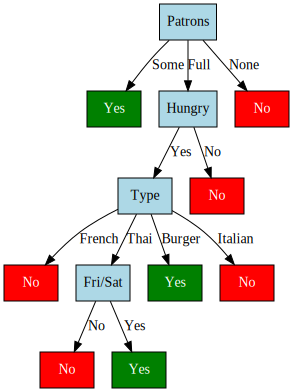

In [47]:
dot = graphviz.Digraph(comment='Restaurant Decision Tree')
dot.attr(rankdir='TB')
dec_tree.create_graph(dot)

Evaluate the decision tree with each input vector from the training set.  Verify that the calculated output matches the expected output for each example.

In [48]:
dec_tree_output = []
for index, row in df.iterrows():
    # Convert the row to a Series
    row_series = row.copy()
    # Remove the last value ("Output")
    row_series = row_series[:-1]
    # Print the modified row
    #print(f"\nModified Row {index}:")
    #print(row_series)
    output_row = {
        'Expected Output': row['Output'],
        'Actual Output': dec_tree.evaluate(row_series),
        'Pass': row['Output'] == dec_tree.evaluate(row_series),
    }
    dec_tree_output.append(output_row)

df_output = pd.DataFrame(dec_tree_output)
df_output

#    print(row['Output'],dec_tree.evaluate(row_series))

,Expected Output,Actual Output,Pass
0,Yes,Yes,True
1,No,No,True
2,Yes,Yes,True
3,Yes,Yes,True
4,No,No,True
5,Yes,Yes,True
6,No,No,True
7,Yes,Yes,True
8,No,No,True
9,No,No,True


One error that needs to be fixed is that there is no transition for a French restaurant in the decision tree.  We can stimulate this error by changing the row 4 "Hungry" attribute to "Yes".

In [ ]:
#test_row = df.iloc[4]
#test_row["Hungry"] = 'Yes'
#print(dec_tree.evaluate(test_row))

## Run XOR through the learning algorithm.
This is a suggestion from the book to illustrate that "early stopping" can lead to missing out on combinations of attributes that are informative.

In [ ]:
xor_data = {'col1': ['0', '0', '1', '1'], 'col2': ['0', '1', '0', '1'], 'Output' : ['0', '1', '1', '0']}
df_xor = pd.DataFrame(xor_data)
print(df_xor)


  col1 col2 Output
0    0    0      0
1    0    1      1
2    1    0      1
3    1    1      0


In [ ]:
dec_tree_xor = learn_decision_tree(df_xor, df_xor, 'root')

Created node for: col1
0
Created node for: col2
0
Created node for: 0
1
Created node for: 1
1
Created node for: col2
0
Created node for: 1
1
Created node for: 0


In [ ]:
print_tree(dec_tree_xor)

Node: col1, Branch: root
  Node: col2, Branch: 0
    Node: 0, Branch: 0
    Node: 1, Branch: 1
  Node: col2, Branch: 1
    Node: 1, Branch: 0
    Node: 0, Branch: 1


1_1
2_1
3_1
3_2
2_4
3_4
3_5


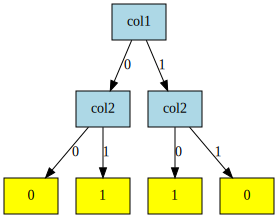

In [ ]:
dot_xor = graphviz.Digraph(comment='XOR Decision Tree')
dot_xor.attr(rankdir='TB')
dec_tree_xor.create_graph(dot_xor)

# **Archived code snippets below here:**

In [ ]:
import os

In [ ]:
os.listdir()

In [ ]:
os.remove('restaurant.csv')

In [ ]:
uploaded['restaurant.csv']

In [ ]:
df['Output'][4]

In [ ]:
plurality_value(df.iloc[0:11])

In [ ]:
df.iloc[2:5]['Output'].value_counts().idxmax()

In [ ]:
grouped = df.groupby('Patrons')
dfs = {city: group for city, group in grouped}
grouped.groups

In [ ]:
group_df['Output'].value_counts()

In [ ]:
x = grouped.get_group('Full')['Output'].value_counts()
#x['Yes'] + x['No']
x.index

In [ ]:
dfs.keys()

In [ ]:
def remaining_entropy_old(groups, tot_examples):
    for value, group_df in groups:
        print(f"DataFrame for value: {value}")
        counts_series = group_df['Output'].value_counts()
        tot_yes = counts_series['Yes']
        tot_examples_this_value = len(group_df)
        print(tot_yes)
        print(len(group_df))
        print(entropy_boolean(tot_yes/tot_examples_this_value))
        print(tot_examples_this_value/tot_examples)
        print()
        print()

In [ ]:
df.iloc[0:11]

Possibly use Graphviz to visualize tree in the future.

In [ ]:
dot = graphviz.Digraph(comment='The Round Table')

dot.node('A', 'Patrons?')
dot.node('B', 'No')
dot.node('L', 'Yes')
dot.node('C', 'Hungry')
dot.node('D', 'Test')

dot.edge('A', 'B', label='None')
dot.edge('A', 'L', label='Some')
dot.edge('A', 'C', label='Full')
dot.edge('C', 'D', label='New Level')
#dot.edges(['AB', 'AL'])
#dot.edge('B', 'L', constraint='false')

dot